In [9]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0-rc1


## **Introduction**

This kernel uses a deep CONVNET that was trained on Google GPU to perform Race Classification on a zipped file containing faces of different races.

Each of the image are either labelled as:

- Caucasian: includes people of American and European descent, also known as whites
- Mongoloid: includes people of Asian descent, especially Eastern Asian
- Negroid: includes people of African descent or black Americans

The zip Dataset contains various images of faces of different races with which I'll use to build an image classifier using a ***tf.keras.Sequential.model*** and build a data(data pipline) using ***tf.keras.preprocessing.image.ImageDataGenerator***.


This project workflow includes:

- Load the zipped dataset from my google drive
- Examining and understanding the dataset
- Building an input pipeline
- Building the model
- Training a CNN model
- Testing the model
- Use the model for prediction on unseen data


All these will be done with tensorflow 2.x.

## **Loading The Image Data from Google Drive**

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()

drive = GoogleDrive(gauth)

In [0]:
fid = drive.ListFile({'q':"title='Racist.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('Racist.zip')

In [14]:
!unzip Racist.zip

Archive:  Racist.zip
   creating: Racist/Test/
   creating: Racist/Test/Caucasian/
  inflating: Racist/Test/Caucasian/12.JPG  
  inflating: Racist/Test/Caucasian/13.JPG  
  inflating: Racist/Test/Caucasian/19.JPG  
  inflating: Racist/Test/Caucasian/20.JPG  
  inflating: Racist/Test/Caucasian/27.JPG  
  inflating: Racist/Test/Caucasian/30.JPG  
  inflating: Racist/Test/Caucasian/38.JPG  
  inflating: Racist/Test/Caucasian/40.JPG  
  inflating: Racist/Test/Caucasian/45.JPG  
  inflating: Racist/Test/Caucasian/49.JPG  
  inflating: Racist/Test/Caucasian/50.JPG  
  inflating: Racist/Test/Caucasian/52.JPG  
  inflating: Racist/Test/Caucasian/55.JPG  
  inflating: Racist/Test/Caucasian/59.JPG  
  inflating: Racist/Test/Caucasian/60.JPG  
  inflating: Racist/Test/Caucasian/61.JPG  
  inflating: Racist/Test/Caucasian/63.JPG  
  inflating: Racist/Test/Caucasian/66.JPG  
  inflating: Racist/Test/Caucasian/67.JPG  
  inflating: Racist/Test/Caucasian/69.JPG  
  inflating: Racist/Test/Caucasian/70

In [0]:
PATH = '/content/Racist'

In [0]:
test_dir = os.path.join(PATH, 'Test')
train_dir = os.path.join(PATH, 'Train')

test_Negroid_dir = os.path.join(test_dir, 'Negroid')
test_Mongoloid_dir = os.path.join(test_dir, 'Mongoloid')
test_Caucasian_dir = os.path.join(test_dir, "Caucasian")

train_Negroid_dir = os.path.join(train_dir, 'Negroid')
train_Mongoloid_dir = os.path.join(train_dir, 'Mongoloid')
train_Caucasian_dir = os.path.join(train_dir, "Caucasian")

## **Overview of the Data**

In [17]:
num_Negroid_tst = len(os.listdir(test_Negroid_dir))
num_Mongoloid_tst = len(os.listdir(test_Mongoloid_dir))
num_Caucasian_tst = len(os.listdir(test_Caucasian_dir))


num_Negroid_tr = len(os.listdir(train_Negroid_dir))
num_Mongoloid_tr = len(os.listdir(train_Mongoloid_dir))
num_Caucasian_tr = len(os.listdir(train_Caucasian_dir))


total_train = num_Negroid_tr + num_Mongoloid_tr + num_Caucasian_tr
total_test =  num_Negroid_tst + num_Mongoloid_tst + num_Caucasian_tst

print('total training Negroid images:', num_Negroid_tr)
print('total training Mongoloid images:', num_Mongoloid_tr)
print('total training Caucasian images:', num_Caucasian_tr)

print('total test Negroid images:', num_Negroid_tst)
print('total test Mongoloid images:', num_Mongoloid_tst)
print('total test Caucasian images:', num_Caucasian_tst)

print("--")

print("Total training images:", total_train)
print("Total test images:", total_test)

total training Negroid images: 517
total training Mongoloid images: 662
total training Caucasian images: 473
total test Negroid images: 26
total test Mongoloid images: 23
total test Caucasian images: 27
--
Total training images: 1652
Total test images: 76


##**Build an input pipeline**

In [0]:
batch_size = 100
epochs = 10
IMG_HEIGHT = 100
IMG_WIDTH = 100

In [19]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
test_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')

Found 1651 images belonging to 3 classes.


In [20]:
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical')

Found 74 images belonging to 3 classes.


### **Visualize the Image**

In [0]:
sample_training_images, _ = next(train_data_gen)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

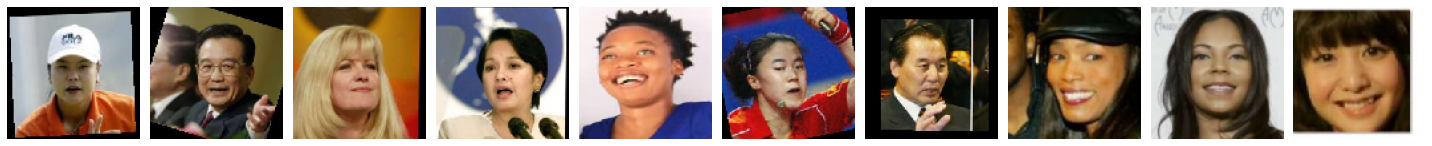

In [22]:
plotImages(sample_training_images[:10])

## **Data augmentation**

- Before I build the model's architecture, from the kernel above we found out that the training example is small compared to datasets usually passed into a Convnet. 

- When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples — to an extent that it negatively impacts the performance of the model on new examples.

- So to avoid overfitting I'll need to augment the dataset so that it has a sufficient or more number of training examples.
  This helps expose the model to more aspects of the data and generalize better.


In [0]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [24]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='categorical')

Found 1651 images belonging to 3 classes.


In [25]:
image_gen_test = ImageDataGenerator(rescale=1./255)
test_data_gen = image_gen_test.flow_from_directory(batch_size=batch_size,
                                                 directory=test_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='categorical')

Found 74 images belonging to 3 classes.


## **Build a CNN Model**

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [0]:
model = Sequential([
    
    # Block 1
    Conv2D(100, (3,3), activation='relu', padding="same",
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    Conv2D(200, (3,3), padding="same", activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    #Block 2
    Conv2D(400, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    Conv2D(400, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    #Block 3
    Conv2D(800, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    Conv2D(800, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    


    #Block 4
    Flatten(),
    Dense(400, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(800, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(3, activation="softmax")
])

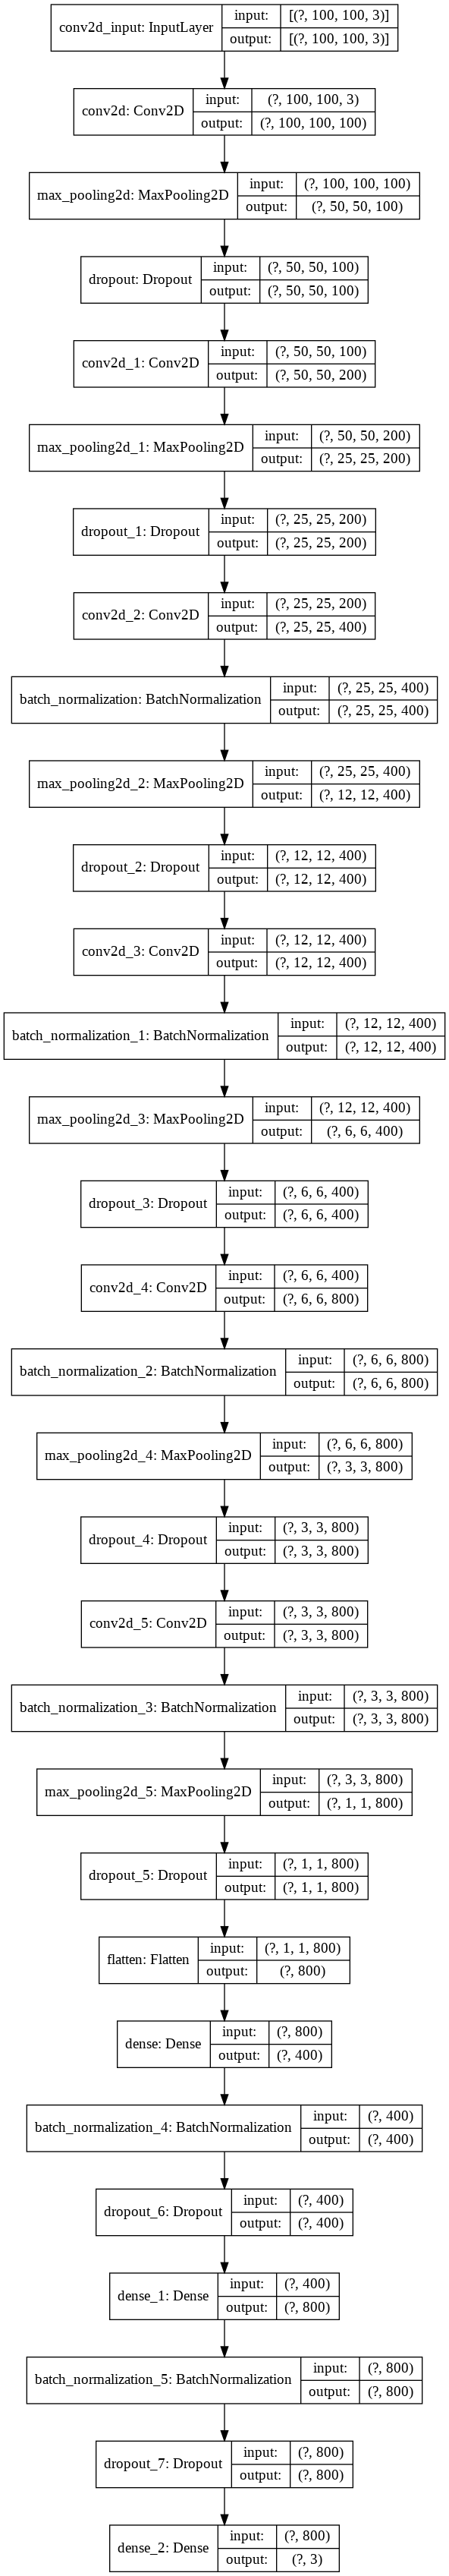

In [27]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [0]:
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.0001)

In [29]:
model.compile(optimizer=opt,
                  loss="categorical_crossentropy",
                  metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 100)     2800      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 100)       0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 100)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 200)       180200    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 200)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 25, 200)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 400)       7

## **Train a Model and Save Best model Using Callbacks**

In [0]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train,  #batch_size
    epochs=epochs,
    validation_data=test_data_gen,
    validation_steps=total_test, #batch_size
    callbacks=callbacks_list
)

Epoch 1/10
1652/1652 [==============================] - ETA: 0s - loss: 0.9381 - accuracy: 0.5920
Epoch 00001: val_accuracy improved from -inf to 0.37838, saving model to model_weights.h5
1652/1652 [==============================] - 946s 573ms/step - loss: 0.9381 - accuracy: 0.5920 - val_loss: 2.1074 - val_accuracy: 0.3784
Epoch 2/10
1652/1652 [==============================] - ETA: 0s - loss: 0.5343 - accuracy: 0.7799
Epoch 00002: val_accuracy improved from 0.37838 to 0.75676, saving model to model_weights.h5
1652/1652 [==============================] - 942s 570ms/step - loss: 0.5343 - accuracy: 0.7799 - val_loss: 0.8727 - val_accuracy: 0.7568
Epoch 3/10
1652/1652 [==============================] - ETA: 0s - loss: 0.2597 - accuracy: 0.8996
Epoch 00003: val_accuracy improved from 0.75676 to 0.78378, saving model to model_weights.h5
1652/1652 [==============================] - 950s 575ms/step - loss: 0.2597 - accuracy: 0.8996 - val_loss: 0.5225 - val_accuracy: 0.7838
Epoch 4/10
1652/165

## **Predict on New Images**

In [30]:
%pylab inline
import matplotlib.image as mpimg
import tensorflow as tf
import cv2
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import model_from_json

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [0]:
model_architecture = 'ImageModel.json'
model_weights = 'model_weights.h5'

model = model_from_json(open(model_architecture).read())
model.load_weights(model_weights)

In [0]:
def predict_race(im):
  
    im = cv2.resize(cv2.imread(im), (100, 100))
    im = im.astype(np.float32)
    im = np.expand_dims(im, axis=0)
    im = im / 255

    out = model.predict(im)
    pred = np.argmax(out)


    if pred == 0:
        return"Caucasian"
    elif pred == 1:
        return "Mongoloid"
    elif pred == 2:
        return "Negroid"

In [0]:
def show_image_and_race(im):
    img=mpimg.imread(im)
    imgplot = plt.imshow(img)
    plt.xlabel("{}".format(predict_race(im)), size = 30)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.show()

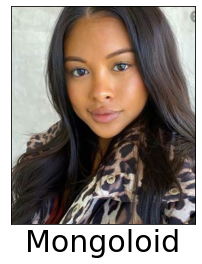

In [34]:
Ammika_Harris = "go.JPG"
show_image_and_race(Ammika_Harris)

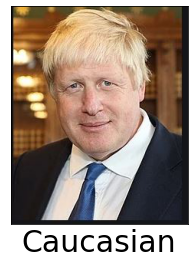

In [35]:
Boris_johnson = "boris.JPG"
show_image_and_race(Boris_johnson)

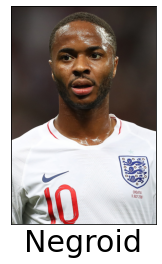

In [36]:
Sterling = "sterling.jpg"
show_image_and_race(Sterling)

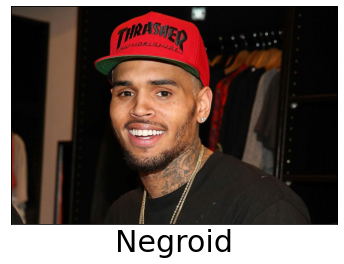

In [37]:
Chris_Brown = "gh.jpg"
show_image_and_race(Chris_Brown)